# Goals
1. Figure out how to do cross-validation with time-series
2. Determine an appropriate evaluation metric for our model

In [21]:
%config Completer.use_jedi = False

In [30]:
from pmdarima.model_selection import train_test_split
from pmdarima.model_selection import cross_val_score
from pmdarima.model_selection import SlidingWindowForecastCV
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
df = sm.datasets.sunspots.load_pandas().data
print(df.shape)
df.head()

(309, 2)


,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [52]:
TARGET = 'SUNACTIVITY'

In [24]:
df = df.set_index('YEAR')

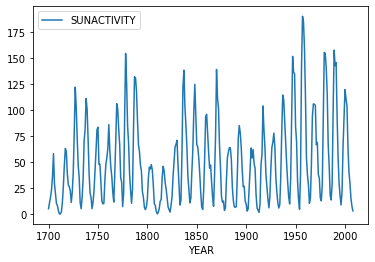

In [25]:
df.plot()

In [26]:
import plotly.express as px
fig = px.line(df, y="SUNACTIVITY")
fig.show()

In [27]:
from statsmodels.tsa.stattools import adfuller
# fig, ax = plt.subplots(figsize=(20,10))
print('Augmented Dickey-Fuller Test Result:', adfuller(df.diff(12).dropna())[:2])

Augmented Dickey-Fuller Test Result: (-5.139462160556142, 1.1671443243307128e-05)


In [17]:
import pmdarima as pm

results = pm.auto_arima( 
    df,             # data
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    seasonal=True,  # is the time series seasonal
    m = 10,
    start_P=1,
    start_Q=1,
    max_P=2,
    max_Q=2,
)

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1280.477
Date:                Mon, 04 Jul 2022   AIC                           2572.954
Time:                        13:38:51   BIC                           2595.335
Sample:                             0   HQIC                          2581.903
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6145      0.026     62.096      0.000       1.564       1.665
ar.L2         -0.9354      0.022    -41.820      0.000      -0.979      -0.892
ma.L1         -1.4392      0.059    -24.590      0.000      -1.554      -1.324
ma.L2          0.4545      0.095      4.783      0.000       0.268       0.641
ma.L3          0.1285      0.060      2.143      0.032       0.011       0.246
sigma2       236.7573     16.333     14.495      0.000     204.744     268.770
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                43.72
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.54
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

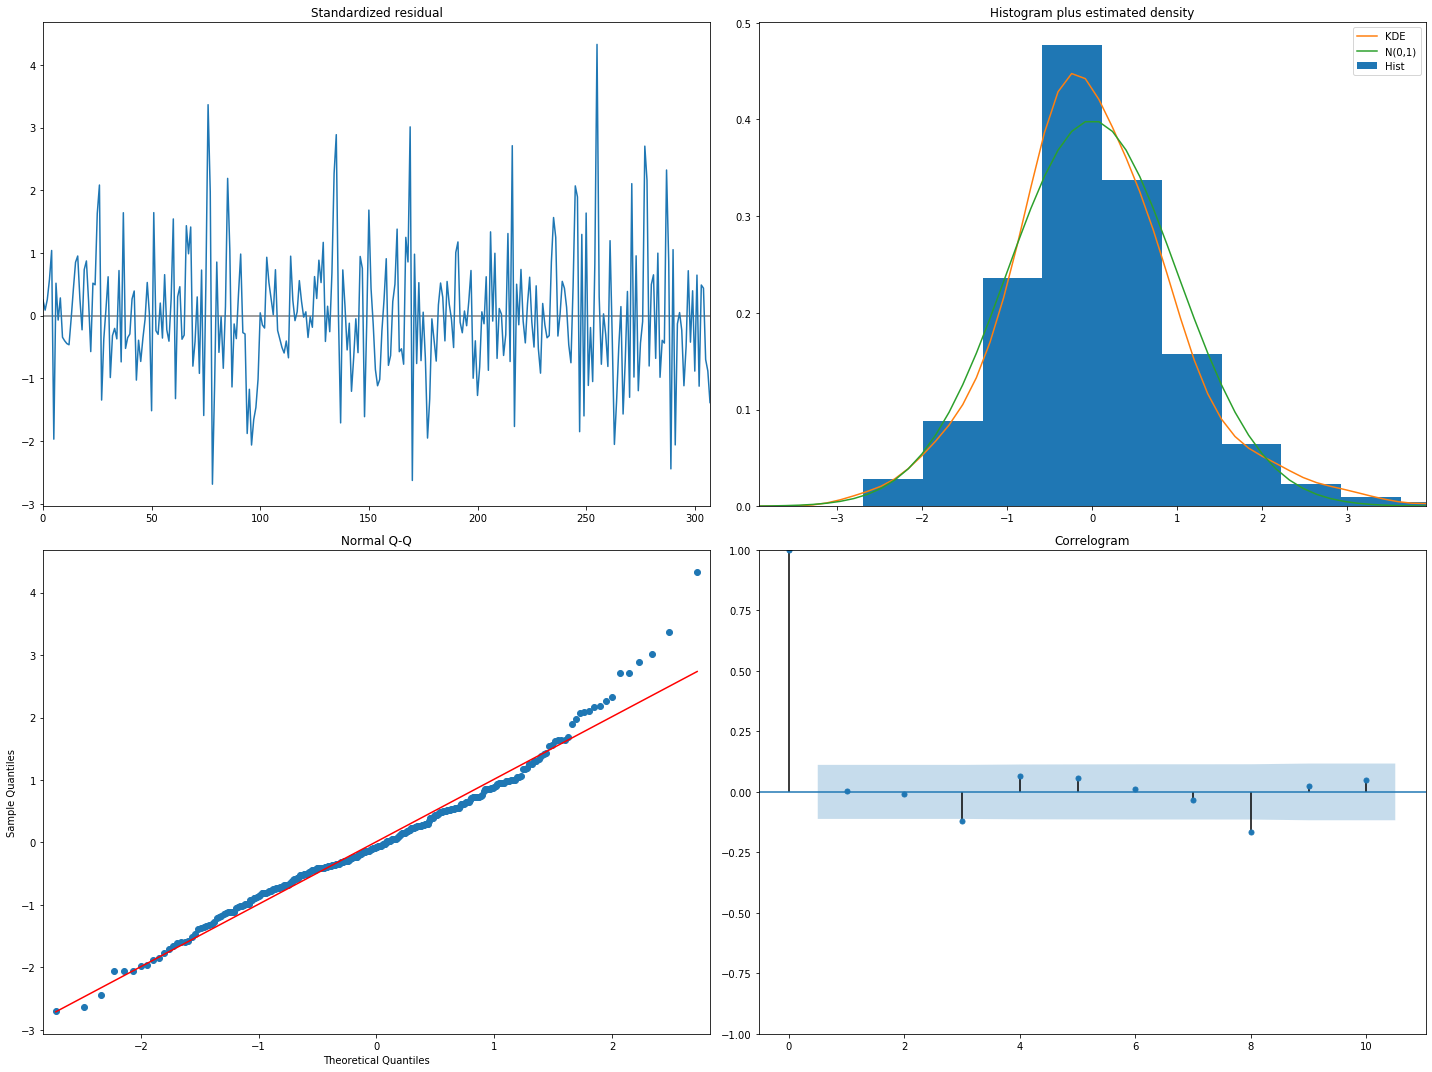

In [43]:
results.plot_diagnostics(figsize=(20,15))
plt.tight_layout()

In [44]:
predictions = results.predict_in_sample()

In [89]:
# forecasts, conf_int = model.predict(n_periods=48, return_conf_int=True)
# plt.plot(forecasts)

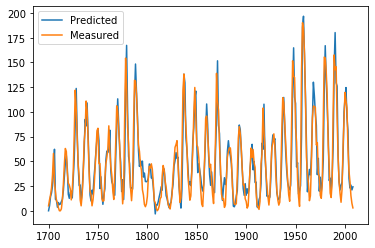

In [45]:
plt.plot(df.index, predictions, label='Predicted')
plt.plot(df['SUNACTIVITY'], label='Measured')
plt.legend()

# Using Cross Validation to Evaluate Model

In [32]:
model = results

In [54]:
# use only test_size pct of data for cross-validation
# train, test = train_test_split(df.reset_index().values, test_size=0.8)

# use whole dataset for cross validation
train = df[TARGET].values

In [56]:
# cv = TimeSeriesSplit(n_splits=5)

# # Iterate through CV splits
# results = []
# for tr, tt in cv.split(X, y):
#     # Fit the model on training data
#     model.fit(X[tr], y[tr])
    
#     # Generate predictions on the test data and collect
#     prediction = model.predict(X[tt])
#     results.append((prediction, tt))

In [59]:
n_samples = df.shape[0]
window_size = n_samples // 5

cv = SlidingWindowForecastCV(h=10, step=window_size, window_size=window_size)

model_cv_scores = cross_val_score(
    model, train, scoring='smape', cv=cv, verbose=2)

print("Model 1 CV scores: {}".format(model_cv_scores.tolist()))

# Use statsmodels SARIMAX

In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [135]:
# Create model object
model = SARIMAX(monthly, 
                order=(1,1,1), 
                seasonal_order=(0,1,1,12), 
                trend='c')

In [136]:
results = model.fit()

In [137]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -123.697
Date:                            Thu, 30 Jun 2022   AIC                            257.394
Time:                                    23:34:02   BIC                            278.595
Sample:                                03-31-1958   HQIC                           265.704
                                     - 12-31-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.001      1.548      0.122      -0.000       0.003
ar.L1          0.2915      0.106      2.746      0.006       0.083       0.500
ma.L1         -0.6180      0.091     -6.791      0.000      -0.796      -0.440
ma.S.L12      -0.8655      0.026    -33.290      0.000      -0.916      -0.815
sigma2         0.0918      0.006     16.203      0.000       0.081       0.103
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.85   Prob(JB):                         0.91
Heteroskedasticity (H):               0.80   Skew:                            -0.01
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

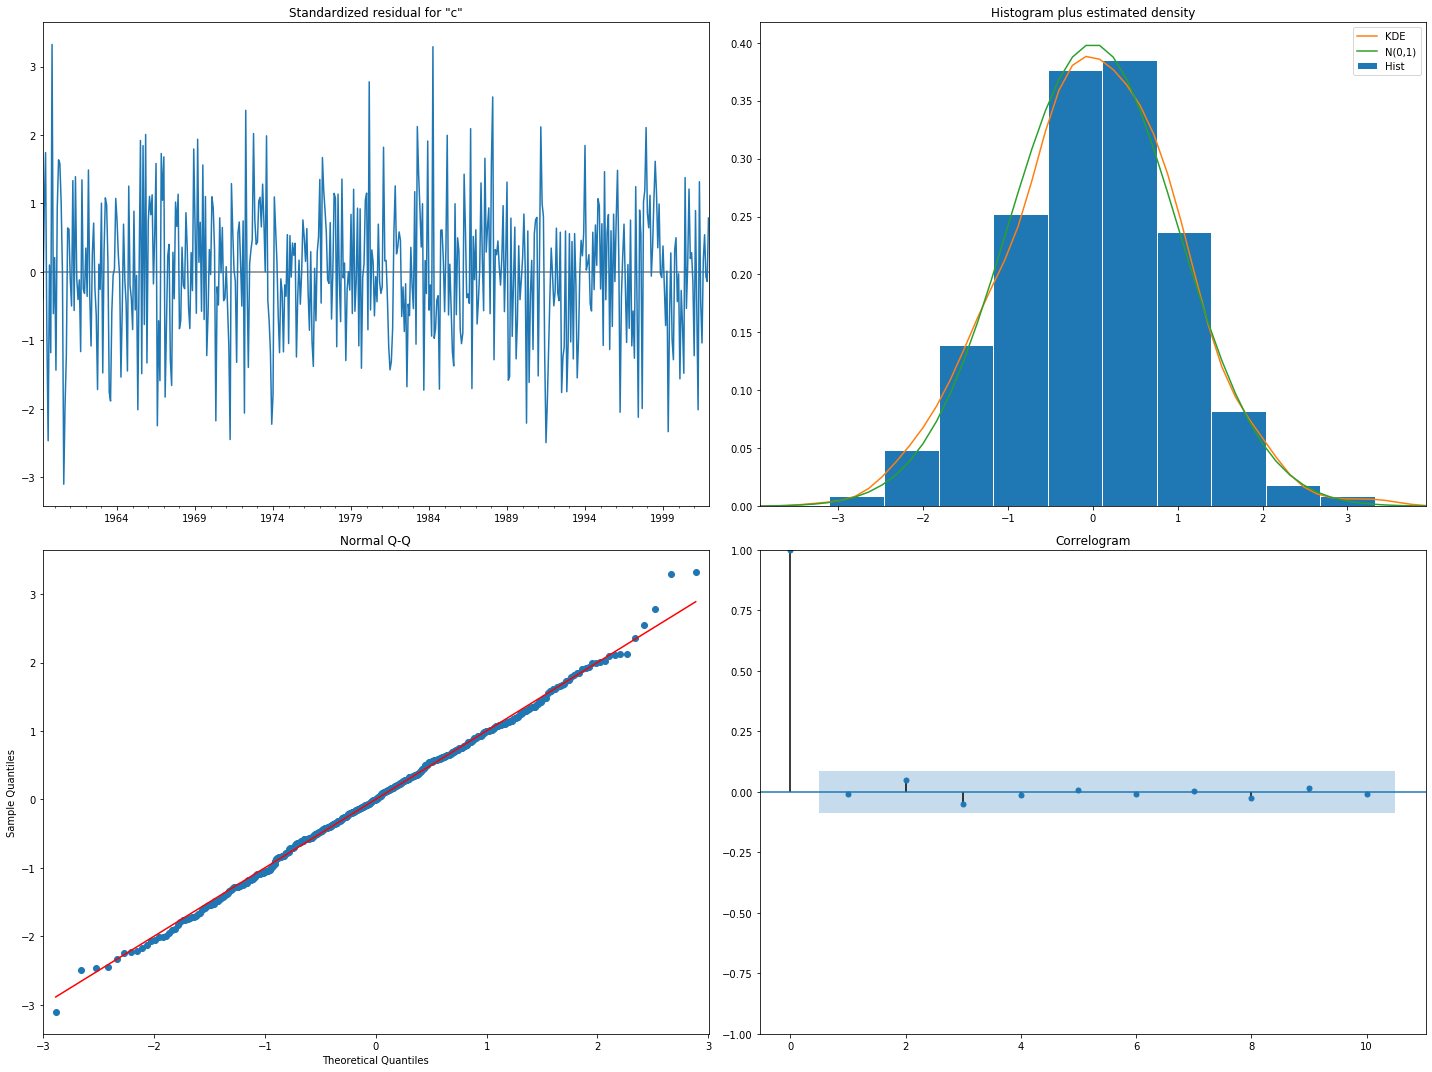

In [138]:
results.plot_diagnostics(figsize=(20,15))
plt.tight_layout()

# Predict - in-sample

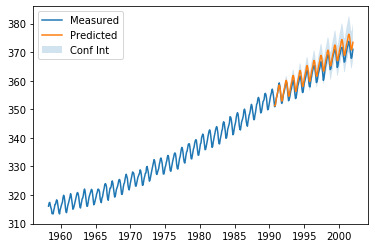

In [139]:
# make dynamice predictions with confidence interval
predictions = results.get_prediction(start=-136, dynamic=True)

mean = predictions.predicted_mean

conf_int = predictions.conf_int()

dates = mean.index

plt.figure()

# Plot past CO2 levels
plt.plot(monthly.index, monthly, label='Measured')

# Plot the prediction means as line
plt.plot(dates, mean, label='Predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int['lower co2'], conf_int['upper co2'], alpha=0.2, label='Conf Int')

# Plot legend and show figure
plt.legend()
plt.show()

# Forecast

Index(['lower co2', 'upper co2'], dtype='object')


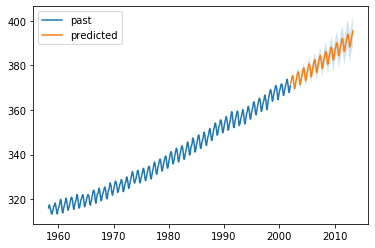

In [140]:
# Create forecast object
forecast_object = results.get_forecast(136)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

print(conf_int.columns)
plt.figure()

# Plot past CO2 levels
plt.plot(monthly.index, monthly, label='past')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int['lower co2'], conf_int['upper co2'], alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.show()